In [2]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
backbone = 'resnet34'
preprocess_input = sm.get_preprocessing(backbone)

In [6]:
SIZE_X = 256
SIZE_Y = 256

In [8]:
# Load and preprocess images
train_images = []
for directory_path in glob.glob(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\defect"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Warning: Failed to load {img_path}")
            continue
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] range
        train_images.append(img)
train_images = np.array(train_images)

print(f"Number of images loaded: {train_images.shape[0]}")

Number of images loaded: 840


In [10]:
# Load and preprocess masks
train_masks = []
for directory_path in glob.glob(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\label"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1] range
        train_masks.append(mask)
train_masks = np.array(train_masks)


In [12]:
# assigining dependent and independent variable
X = train_images
Y = train_masks

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
# Preprocess images
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [18]:
# Define Jaccard Loss function
import tensorflow as tf

def jaccard_loss(y_true, y_pred):
    smooth = 1e-6
    # Ensure that y_true and y_pred are of type float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, (-1,))
    y_pred_f = tf.reshape(y_pred, (-1,))
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return 1 - (intersection + smooth) / (union + smooth)

In [20]:
# Create and compile model
model = sm.Unet(backbone, encoder_weights='imagenet')
model.compile(optimizer='adam', loss=jaccard_loss, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [32]:
import tensorflow as tf

# Changed the file extension from .h5 to .keras
check_point = tf.keras.callbacks.ModelCheckpoint('segmentation_model.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

In [34]:
history=model.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8143 - loss: 0.5988 - val_accuracy: 0.3691 - val_loss: 0.8256
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9709 - loss: 0.2143 - val_accuracy: 0.3347 - val_loss: 0.8286
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9728 - loss: 0.1621 - val_accuracy: 0.8199 - val_loss: 0.9964
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9761 - loss: 0.1620 - val_accuracy: 0.6877 - val_loss: 0.8428
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9757 - loss: 0.1398 - val_accuracy: 0.5743 - val_loss: 0.7103
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9754 - loss: 0.1646 - val_accuracy: 0.8199 - val_loss: 0.9998
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9781 - loss: 0.1130 - val_accuracy: 0.8199 - val_loss: 0.9998
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.9786 - loss: 0.1356 - val_accuracy: 0.8350 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


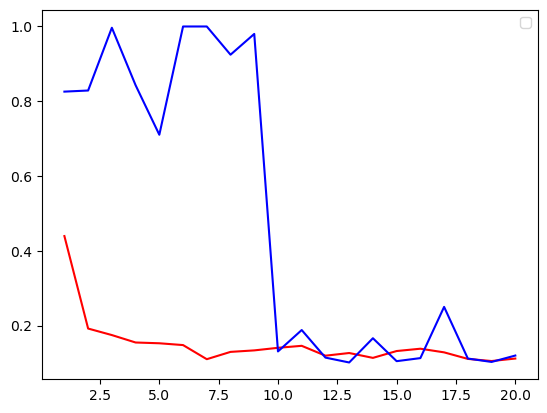

<Figure size 640x480 with 0 Axes>

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs , loss,'r')
plt.plot(epochs,val_loss,'b')
plt.legend()
plt.show()
# Save the figure with high resolution (300 DPI)
plt.savefig('resnet34_training_loss.png', dpi=300, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


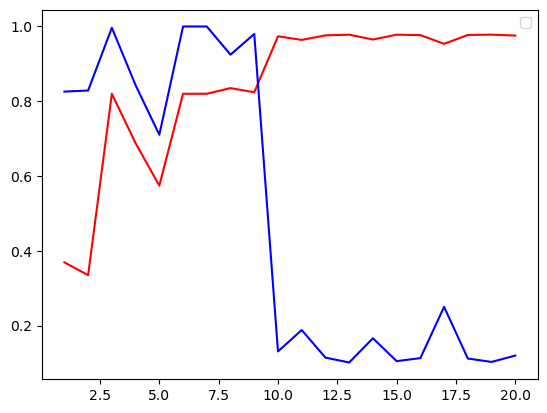

<Figure size 640x480 with 0 Axes>

In [36]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(val_loss)+1)
plt.plot(epochs , val_accuracy,'r')
plt.plot(epochs,val_loss,'b')
plt.legend()
plt.show()
# Save the figure with high resolution (300 DPI)
plt.savefig('resnet34_val_accuracy_val_loss.png', dpi=300, bbox_inches='tight')


In [40]:
import cv2
import numpy as np
from sklearn.metrics import classification_report

# Load and preprocess test image
test_img = cv2.imread(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\test\defect\0860.jpg", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = np.expand_dims(test_img, axis=0)

# Preprocess the test image (optional if preprocess_input was used)
test_img = preprocess_input(test_img)

# Predict on the test images
y_pred = model.predict(x_test)

# Apply threshold to get binary predictions
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Apply threshold to the true test masks to make them binary
y_test_thresholded = (y_test > 0.5).astype(np.uint8)

# Flatten the predictions and true labels for classification report
y_test_flat = y_test_thresholded.flatten()
y_pred_flat = y_pred_thresholded.flatten()

# Generate classification report
report = classification_report(y_test_flat, y_pred_flat)
print(report)


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   9089892
           1       0.99      0.91      0.95   1920156

    accuracy                           0.98  11010048
   macro avg       0.98      0.95      0.97  11010048
weighted avg       0.98      0.98      0.98  11010048



In [42]:
# IoU score
iou_metric = keras.metrics.MeanIoU(num_classes=2)
iou_metric.update_state(y_test, y_pred_thresholded)
iou_score = iou_metric.result().numpy()
print(f'IoU Score: {iou_score:.4f}')

IoU Score: 0.9453


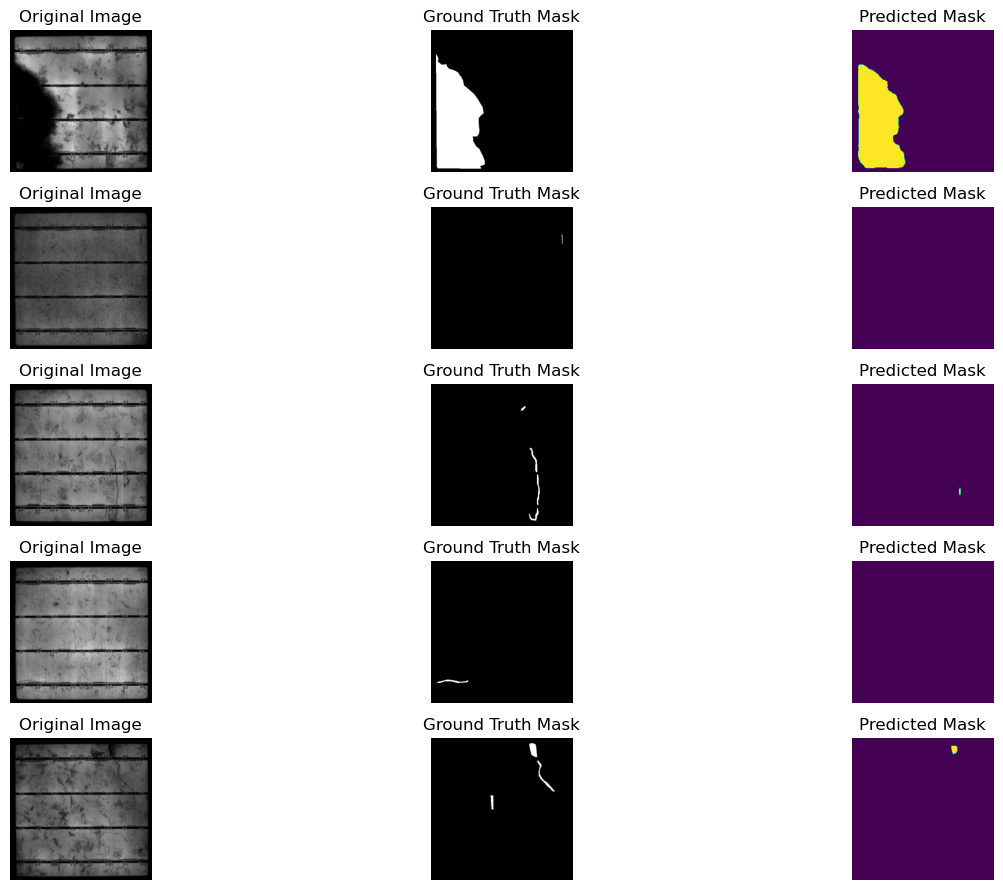

<Figure size 640x480 with 0 Axes>

In [44]:
# Visualize predictions and ground truth
num_samples = min(len(x_test), 5)  # Adjust number of samples to visualize
plt.figure(figsize=(15, 9))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_test[i],cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(y_pred_thresholded[i]) ##pixels with threshold above 0.5 is considered as the predicted pixel masks
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()
# Save the figure with high resolution (300 DPI)
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')


In [66]:
##Now applying the VGG16
backbone = "vgg16"
preprocess_input = sm.get_preprocessing(backbone)

In [68]:
model_vgg16 = sm.Unet(backbone, encoder_weights='imagenet')
model_vgg16.compile(optimizer='adam', loss=jaccard_loss, metrics=['accuracy'])

print(model_vgg16.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, None,      │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, None,      │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, None,      │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, None,      │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, None,      │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, None,      │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, None,      │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, None,      │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, None,      │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, None,      │  2,359,808 │ block5_conv1[0][

 Total params: 23,752,273 (90.61 MB)

 Trainable params: 23,748,241 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

None


In [70]:
history_2=model_vgg16.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 545s 6s/step - accuracy: 0.7768 - loss: 0.6321 - val_accuracy: 0.1699 - val_loss: 0.8261
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.9591 - loss: 0.2780 - val_accuracy: 0.2471 - val_loss: 0.8082
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.9705 - loss: 0.1856 - val_accuracy: 0.8823 - val_loss: 0.4704
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 423s 5s/step - accuracy: 0.9747 - loss: 0.1514 - val_accuracy: 0.3331 - val_loss: 0.7922
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 412s 5s/step - accuracy: 0.9701 - loss: 0.1771 - val_accuracy: 0.8231 - val_loss: 0.9785
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 418s 5s/step - accuracy: 0.9741 - loss: 0.1616 - val_accuracy: 0.3458 - val_loss: 0.7894
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.9725 - loss: 0.1561 - val_accuracy: 0.9604 - val_loss: 0.2263
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 405s 5s/step - accuracy: 0.9771 - loss: 0.1646 - val_accuracy: 0.8199 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


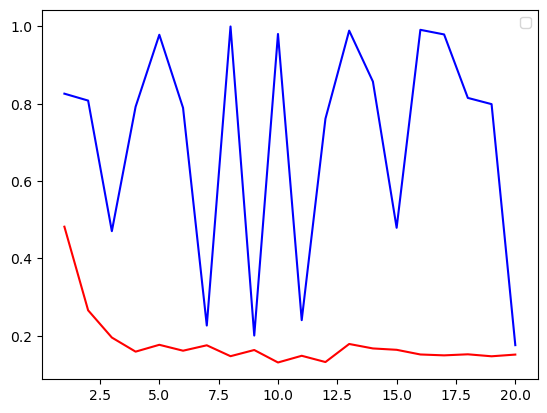

In [76]:
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs = range(1,len(loss_2)+1)
plt.plot(epochs , loss_2,'r')
plt.plot(epochs,val_loss_2,'b')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


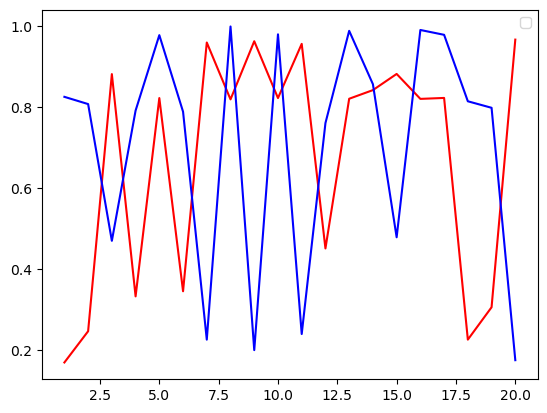

In [74]:
val_accuracy_2 = history_2.history['val_accuracy']
val_loss_2 = history_2.history['val_loss']
epochs = range(1,len(val_loss_2)+1)
plt.plot(epochs , val_accuracy_2,'r')
plt.plot(epochs,val_loss_2,'b')
plt.legend()
plt.show()

In [80]:
import cv2
import numpy as np
from sklearn.metrics import classification_report

# Load and preprocess test image
test_img = cv2.imread(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\defect\0005.jpg", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = np.expand_dims(test_img, axis=0)

# Preprocess the test image (optional if preprocess_input was used)
test_img = preprocess_input(test_img)

# Predict on the test images
y_pred_2 = model_vgg16.predict(x_test)

# Apply threshold to get binary predictions
y_pred_thresholded_2 = (y_pred_2 > 0.5).astype(np.uint8)

# Apply threshold to the true test masks to make them binary
y_test_thresholded_2 = (y_test > 0.5).astype(np.uint8)

# Flatten the predictions and true labels for classification report
y_test_flat_2 = y_test_thresholded_2.flatten()
y_pred_flat_2 = y_pred_thresholded_2.flatten()

# Generate classification report
report = classification_report(y_test_flat_2, y_pred_flat_2)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98   9089892
           1       0.98      0.87      0.92   1920156

    accuracy                           0.97  11010048
   macro avg       0.97      0.93      0.95  11010048
weighted avg       0.97      0.97      0.97  11010048



In [82]:
# IoU score
iou_metric_2 = keras.metrics.MeanIoU(num_classes=2)
iou_metric_2.update_state(y_test, y_pred_thresholded_2)
iou_score_2 = iou_metric_2.result().numpy()
print(f'IoU Score: {iou_score_2:.4f}')

IoU Score: 0.9170


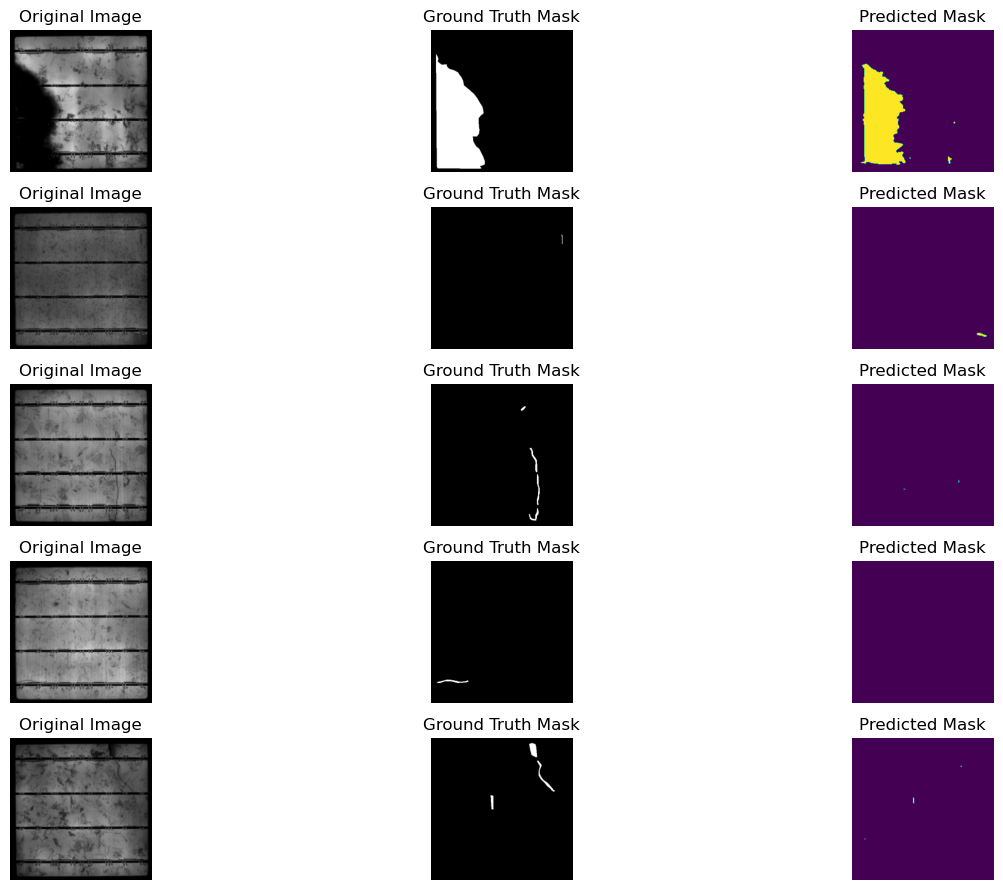

In [84]:
# Visualize predictions and ground truth
num_samples = min(len(x_test), 5)  # Adjust number of samples to visualize
plt.figure(figsize=(15, 9))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_test[i],cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(y_pred_thresholded_2[i]) ##pixels with threshold above 0.5 is considered as the predicted pixel masks
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [86]:
##Now applying the 'inceptionv3'
backbone = 'inceptionv3'
preprocess_input = sm.get_preprocessing(backbone)

In [94]:
model_inceptionv3 = sm.Unet(backbone, encoder_weights='imagenet')
model_inceptionv3.compile(optimizer='adam', loss=jaccard_loss, metrics=['accuracy'])

print(model_inceptionv3.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, None,      │        864 │ input_layer_3[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, None,      │      9,216 │ activation_188[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, None,      │     18,432 │ activation_189[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, None,      │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_8[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, None,      │    138,240 │ activation_191[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, None,      │          0 │ batch_normalizat

 Total params: 29,933,105 (114.19 MB)

 Trainable params: 29,896,689 (114.05 MB)

 Non-trainable params: 36,416 (142.25 KB)

None


In [96]:
history_3=model_inceptionv3.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.8449 - loss: 0.5832 - val_accuracy: 0.8271 - val_loss: 0.9559
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9698 - loss: 0.2402 - val_accuracy: 0.9168 - val_loss: 0.4075
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.9731 - loss: 0.1300 - val_accuracy: 0.9648 - val_loss: 0.1751
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9768 - loss: 0.1403 - val_accuracy: 0.9701 - val_loss: 0.1513
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9772 - loss: 0.1189 - val_accuracy: 0.8261 - val_loss: 0.7409
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9791 - loss: 0.1383 - val_accuracy: 0.6525 - val_loss: 0.6855
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.9786 - loss: 0.1200 - val_accuracy: 0.9593 - val_loss: 0.2038
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9802 - loss: 0.1276 - val_accuracy: 0.8970 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


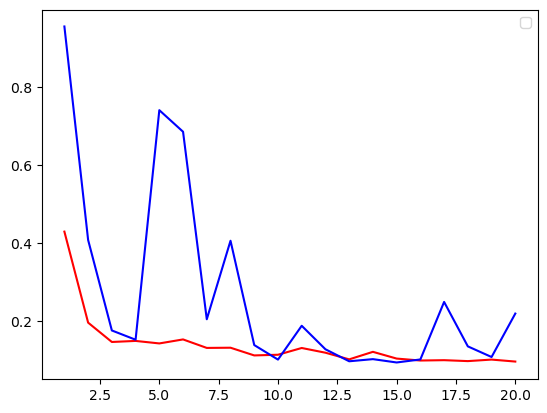

In [98]:
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']
epochs = range(1,len(loss_3)+1)
plt.plot(epochs , loss_3,'r')
plt.plot(epochs,val_loss_3,'b')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


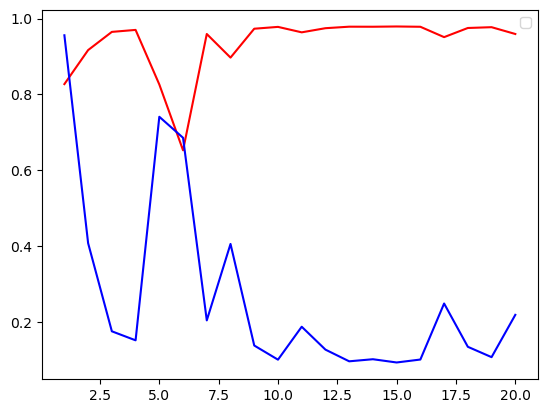

In [100]:
val_accuracy_3 = history_3.history['val_accuracy']
val_loss_3 = history_3.history['val_loss']
epochs = range(1,len(val_loss_3)+1)
plt.plot(epochs , val_accuracy_3,'r')
plt.plot(epochs,val_loss_3,'b')
plt.legend()
plt.show()

In [110]:
import cv2
import numpy as np
from sklearn.metrics import classification_report

# Load and preprocess test image
test_img = cv2.imread(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\defect\0009.jpg", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = np.expand_dims(test_img, axis=0)

# Preprocess the test image (optional if preprocess_input was used)
test_img = preprocess_input(test_img)

# Predict on the test images
y_pred_3 = model_inceptionv3.predict(x_test)

# Apply threshold to get binary predictions
y_pred_thresholded_3 = (y_pred_3 > 0.5).astype(np.uint8)

# Apply threshold to the true test masks to make them binary
y_test_thresholded_3 = (y_test > 0.5).astype(np.uint8)

# Flatten the predictions and true labels for classification report
y_test_flat_3 = y_test_thresholded_3.flatten()
y_pred_flat_3 = y_pred_thresholded_3.flatten()

# Generate classification report
report_3 = classification_report(y_test_flat_3, y_pred_flat_3)
print(report_3)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98   9089892
           1       0.87      0.94      0.91   1920156

    accuracy                           0.97  11010048
   macro avg       0.93      0.96      0.94  11010048
weighted avg       0.97      0.97      0.97  11010048



In [114]:
# IoU score
iou_metric_3 = keras.metrics.MeanIoU(num_classes=2)
iou_metric_3.update_state(y_test, y_pred_thresholded_3)
iou_score_3 = iou_metric_3.result().numpy()
print(f'IoU Score: {iou_score_3:.4f}')

IoU Score: 0.8934


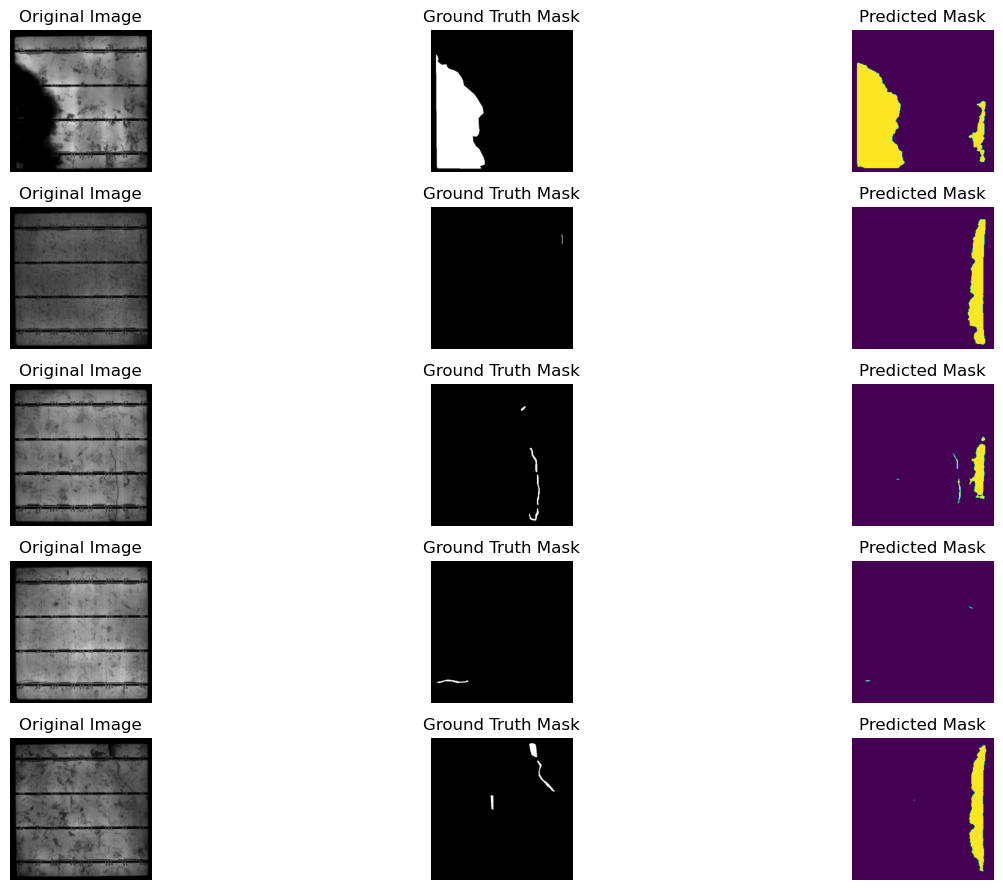

In [116]:
# Visualize predictions and ground truth
num_samples = min(len(x_test), 5)  # Adjust number of samples to visualize
plt.figure(figsize=(15, 9))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_test[i],cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(y_pred_thresholded_3[i]) ##pixels with threshold above 0.5 is considered as the predicted pixel masks
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
##Now applying the 'inceptionv3'
backbone = 'inceptionresnetv2'
preprocess_input = sm.get_preprocessing(backbone)

In [25]:
model_inceptionresnetv2 = sm.Unet(backbone, encoder_weights='imagenet')
model_inceptionresnetv2.compile(optimizer='adam', loss=jaccard_loss, metrics=['accuracy'])

print(model_inceptionresnetv2.summary())

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 390s 2us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, None,      │        864 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, None,      │      9,216 │ activation_203[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, None,      │     18,432 │ activation_204[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_205[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, None,      │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_4[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_206[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, None,      │    138,240 │ activation_206[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_207[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, None,      │          0 │ batch_normalizat

 Total params: 62,061,553 (236.75 MB)

 Trainable params: 61,999,025 (236.51 MB)

 Non-trainable params: 62,528 (244.25 KB)

None


In [27]:
history_4=model_inceptionresnetv2.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.8873 - loss: 0.5856 - val_accuracy: 0.9541 - val_loss: 0.3595
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.9750 - loss: 0.1740 - val_accuracy: 0.8933 - val_loss: 0.6155
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9781 - loss: 0.1399 - val_accuracy: 0.9482 - val_loss: 0.2946
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.9800 - loss: 0.1084 - val_accuracy: 0.9759 - val_loss: 0.1244
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.9785 - loss: 0.1600 - val_accuracy: 0.9735 - val_loss: 0.1349
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.9784 - loss: 0.1541 - val_accuracy: 0.5575 - val_loss: 0.7257
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9777 - loss: 0.1352 - val_accuracy: 0.9748 - val_loss: 0.1242
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.9800 - loss: 0.0970 - val_accuracy: 0.9638 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


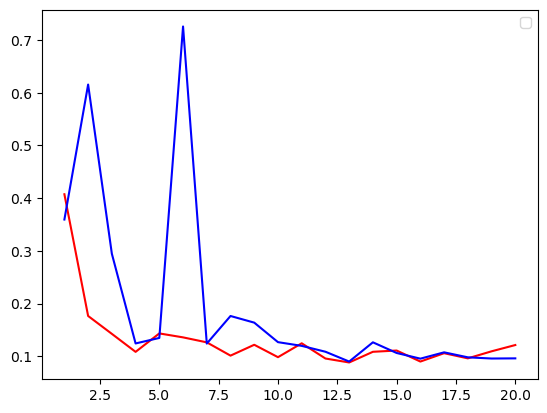

In [29]:
loss_4 = history_4.history['loss']
val_loss_4 = history_4.history['val_loss']
epochs = range(1,len(loss_4)+1)
plt.plot(epochs , loss_4,'r')
plt.plot(epochs,val_loss_4,'b')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


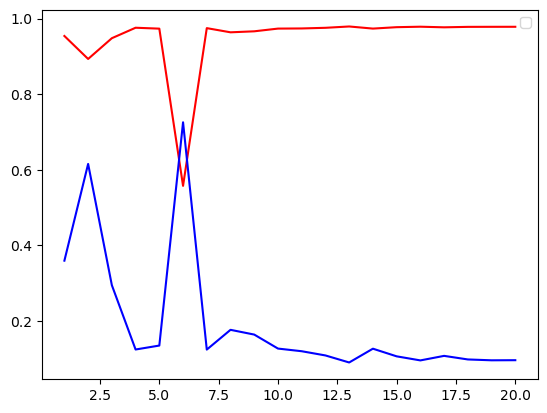

In [31]:
val_accuracy_4 = history_4.history['val_accuracy']
val_loss_4 = history_4.history['val_loss']
epochs = range(1,len(val_loss_4)+1)
plt.plot(epochs , val_accuracy_4,'r')
plt.plot(epochs,val_loss_4,'b')
plt.legend()
plt.show()

In [33]:
import cv2
import numpy as np
from sklearn.metrics import classification_report

# Load and preprocess test image
test_img = cv2.imread(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\defect\0009.jpg", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = np.expand_dims(test_img, axis=0)

# Preprocess the test image (optional if preprocess_input was used)
test_img = preprocess_input(test_img)

# Predict on the test images
y_pred_4 = model_inceptionresnetv2.predict(x_test)

# Apply threshold to get binary predictions
y_pred_thresholded_4 = (y_pred_4 > 0.5).astype(np.uint8)

# Apply threshold to the true test masks to make them binary
y_test_thresholded_4 = (y_test > 0.5).astype(np.uint8)

# Flatten the predictions and true labels for classification report
y_test_flat_4 = y_test_thresholded_4.flatten()
y_pred_flat_4 = y_pred_thresholded_4.flatten()

# Generate classification report
report_4 = classification_report(y_test_flat_4, y_pred_flat_4)
print(report_4)

6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   9089892
           1       0.98      0.93      0.96   1920156

    accuracy                           0.99  11010048
   macro avg       0.98      0.97      0.97  11010048
weighted avg       0.99      0.99      0.99  11010048



In [35]:
# IoU score
iou_metric_4 = keras.metrics.MeanIoU(num_classes=2)
iou_metric_4.update_state(y_test, y_pred_thresholded_4)
iou_score_4 = iou_metric_4.result().numpy()
print(f'IoU Score: {iou_score_4:.4f}')

IoU Score: 0.9509


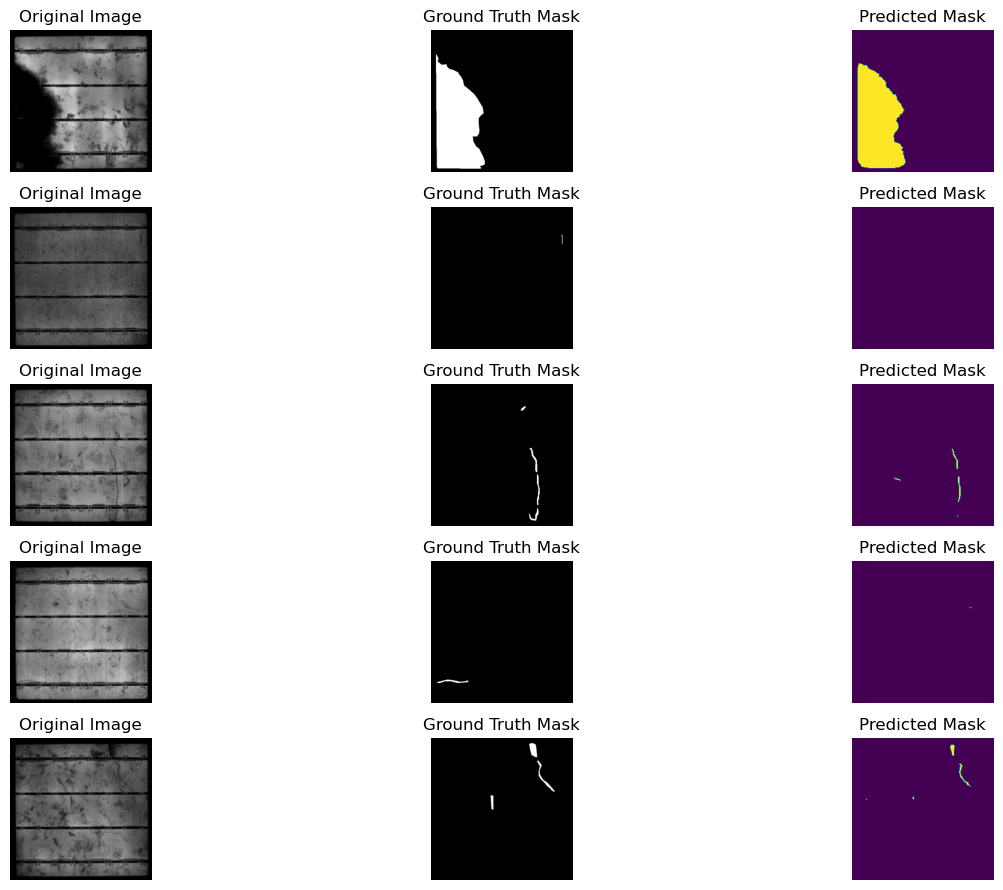

In [37]:
# Visualize predictions and ground truth
num_samples = min(len(x_test), 5)  # Adjust number of samples to visualize
plt.figure(figsize=(15, 9))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_test[i],cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(y_pred_thresholded_4[i]) ##pixels with threshold above 0.5 is considered as the predicted pixel masks
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
backbone = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(backbone)

In [41]:
model_efficientnetb4 = sm.Unet(backbone, encoder_weights='imagenet')
model_efficientnetb4.compile(optimizer='adam', loss=jaccard_loss, metrics=['accuracy'])

print(model_efficientnetb4.summary())

71892840/71892840 ━━━━━━━━━━━━━━━━━━━━ 120s 2us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,296 │ input_layer_2[0]… │
│                     │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 48)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      1,152 │ block1a_se_excit… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, None,      │        216 │ block1a_project_… │
│ (DepthwiseConv2D)   │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, None,      │         96 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, None,      │          0 │ block1b_bn[0][0]

 Total params: 25,735,017 (98.17 MB)

 Trainable params: 25,607,833 (97.69 MB)

 Non-trainable params: 127,184 (496.81 KB)

None


In [43]:
history_5=model_efficientnetb4.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.9160 - loss: 0.5431 - val_accuracy: 0.5326 - val_loss: 0.7523
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9766 - loss: 0.1585 - val_accuracy: 0.7867 - val_loss: 0.5638
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9783 - loss: 0.1241 - val_accuracy: 0.9759 - val_loss: 0.1311
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.9784 - loss: 0.1743 - val_accuracy: 0.9759 - val_loss: 0.1155
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 407s 5s/step - accuracy: 0.9797 - loss: 0.1224 - val_accuracy: 0.9759 - val_loss: 0.1167
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 426s 5s/step - accuracy: 0.9790 - loss: 0.1494 - val_accuracy: 0.9786 - val_loss: 0.0976
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 405s 5s/step - accuracy: 0.9793 - loss: 0.1236 - val_accuracy: 0.9779 - val_loss: 0.1005
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 0.9812 - loss: 0.0950 - val_accuracy: 0.9786 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


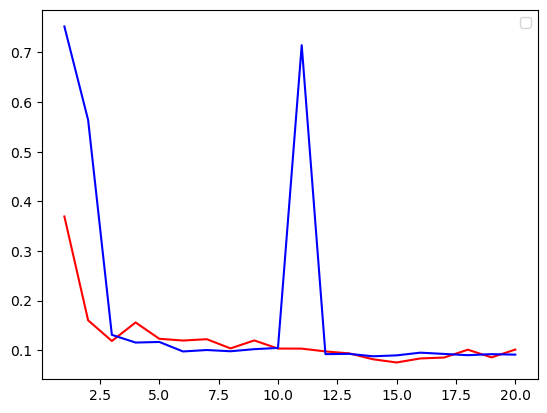

In [45]:
loss_5 = history_5.history['loss']
val_loss_5 = history_5.history['val_loss']
epochs = range(1,len(loss_5)+1)
plt.plot(epochs , loss_5,'r')
plt.plot(epochs,val_loss_5,'b')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


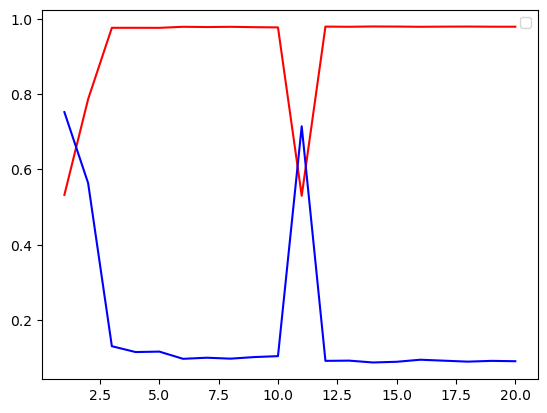

In [47]:
val_accuracy_5 = history_5.history['val_accuracy']
val_loss_5 = history_5.history['val_loss']
epochs = range(1,len(val_loss_5)+1)
plt.plot(epochs , val_accuracy_5,'r')
plt.plot(epochs,val_loss_5,'b')
plt.legend()
plt.show()

In [49]:
import cv2
import numpy as np
from sklearn.metrics import classification_report

# Load and preprocess test image
test_img = cv2.imread(r"C:\Users\snaha\Desktop\DEEP LEARNING PROJECT\archive\data\PVEL_S\train\defect\0009.jpg", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = np.expand_dims(test_img, axis=0)

# Preprocess the test image (optional if preprocess_input was used)
test_img = preprocess_input(test_img)

# Predict on the test images
y_pred_5 = model_efficientnetb4.predict(x_test)

# Apply threshold to get binary predictions
y_pred_thresholded_5 = (y_pred_5 > 0.5).astype(np.uint8)

# Apply threshold to the true test masks to make them binary
y_test_thresholded_5 = (y_test > 0.5).astype(np.uint8)

# Flatten the predictions and true labels for classification report
y_test_flat_5 = y_test_thresholded_5.flatten()
y_pred_flat_5 = y_pred_thresholded_5.flatten()

# Generate classification report
report_5 = classification_report(y_test_flat_5, y_pred_flat_5)
print(report_5)

6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   9089892
           1       0.96      0.96      0.96   1920156

    accuracy                           0.99  11010048
   macro avg       0.98      0.97      0.98  11010048
weighted avg       0.99      0.99      0.99  11010048



In [51]:
# IoU score
iou_metric_5 = keras.metrics.MeanIoU(num_classes=2)
iou_metric_5.update_state(y_test, y_pred_thresholded_5)
iou_score_5 = iou_metric_5.result().numpy()
print(f'IoU Score: {iou_score_5:.4f}')

IoU Score: 0.9491


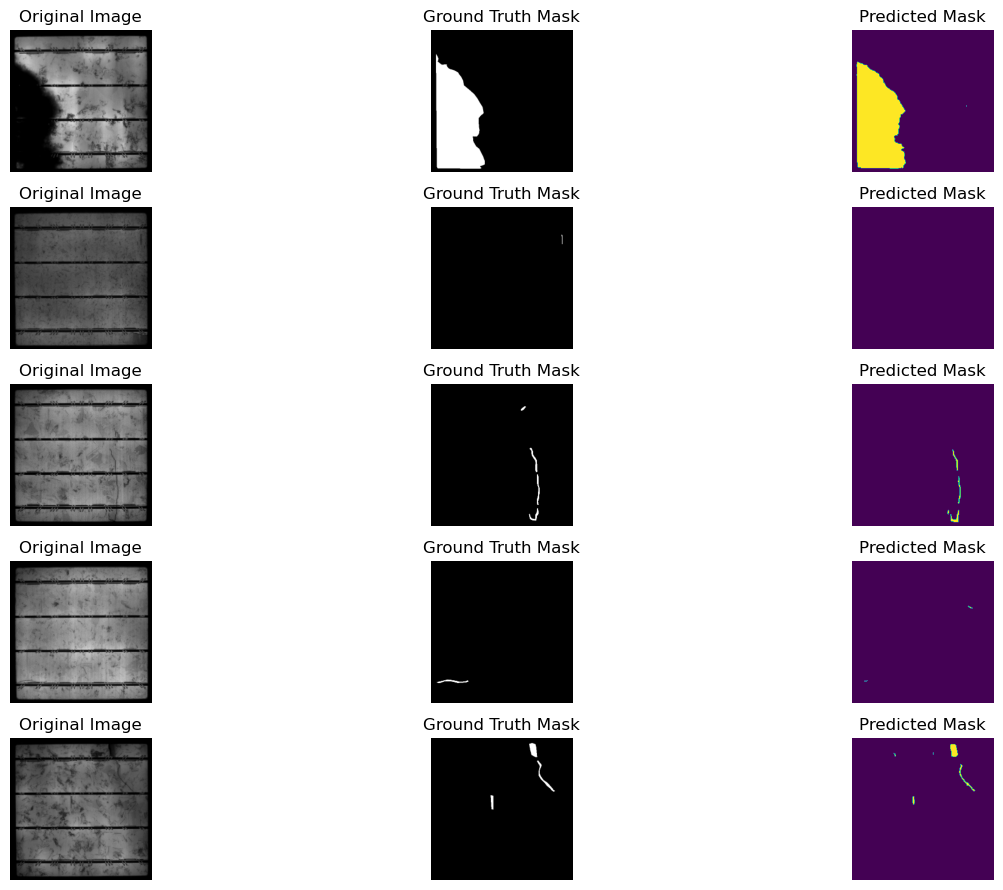

In [53]:
# Visualize predictions and ground truth
num_samples = min(len(x_test), 5)  # Adjust number of samples to visualize
plt.figure(figsize=(15, 9))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(x_test[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_test[i],cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(y_pred_thresholded_5[i]) ##pixels with threshold above 0.5 is considered as the predicted pixel masks
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()